In [1]:
# %matplotlib inline
from numpy.random import RandomState
import numpy
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import string
from sklearn.decomposition import TruncatedSVD

In [19]:
import os
path_to_model = 'C:/Users/prana/Desktop/BE Project/LegalBuddyServer/OPPClassifiers/SecondaryClassifiers/Models/DataRetention/RetentionPurpose.sav'
# os.listdir(path_to_model)

# Create Multilabel Dataset

In [3]:
#preprocess
df = pd.read_csv('dataset.csv')
df = df.dropna()

classes = list(df.Category.unique())
total_unique_clauses = df.Clause.unique().size

#creating dict for appending
classes_dict = {}
for single_class in classes:
    classes_dict[single_class] = list(numpy.zeros(total_unique_clauses))

#creating the df
data = {}
for index,row in df.iterrows():
    try : 
        data[row['Clause']].append(row['Category'])
        data[row['Clause']] = list(set(data[row['Clause']]))  
    except:
        data[row['Clause']] = [row['Category']]

        Clause = []
Category = []
for key in data.keys():
    Clause.append(key)
    Category.append(data[key])
    
data = pd.DataFrame({
    'Clause' : Clause,
    'Category' : Category
})
index = 0
for category_list in data.Category:
    for category in category_list:
        classes_dict[category][index] = 1
    index += 1

classes_dict = pd.DataFrame(classes_dict)

In [4]:
data.head()

,Clause,Category
0,Even if you do not opt-in to receive promotion...,[Perform service]
1,This information may stay in our backup files.,[Unspecified]
2,for our business,[Perform service]
3,"resolve disputes, enforce our agreements",[Service operation and security]
4,otherwise required by law,[Legal requirement]


In [5]:
classes_dict.head()

,Perform service,Unspecified,Service operation and security,Legal requirement,Analytics/Research,Other,Advertising,Marketing
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
one_hot_encoded_data = pd.concat([data, classes_dict], axis=1)
one_hot_encoded_data.drop(columns=['Category']).to_csv('multilabel_dataset.csv')

In [7]:
df = pd.read_csv('multilabel_dataset.csv')
df = df.dropna()
train = df.sample(frac=0.8, random_state = RandomState())
test = df.loc[~df.index.isin(train.index)]
validation = train.sample(frac=0.2, random_state=200)

In [8]:
df.columns.values[2:]

array(['Perform service', 'Unspecified', 'Service operation and security',
       'Legal requirement', 'Analytics/Research', 'Other', 'Advertising',
       'Marketing'], dtype=object)

# Visualizing Data

In [9]:
counts = []
categories = list(df.columns.values[2:])
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,Perform service,88.0
1,Unspecified,76.0
2,Service operation and security,36.0
3,Legal requirement,43.0
4,Analytics/Research,17.0
5,Other,25.0
6,Advertising,3.0
7,Marketing,5.0


Text(0.5, 0, 'category')

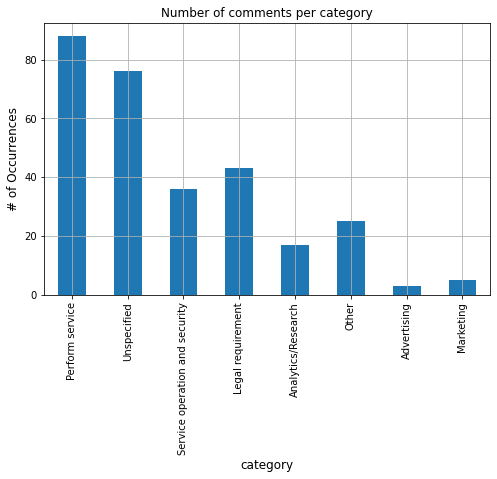

In [10]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

# Preprocessing Data

In [11]:
# cleaned_clause = []
# for clause in df.Clause:
#     clause = clause.lower()
#     clause = re.sub(r'[0-9]+', '',clause) #number removal
#     clause = clause.translate(string.maketrans(“”,””), string.punctuation) #removinf punctuations
#     clause = clause.strip() #whitespace removal
#     clause
#     break

In [12]:
x_test = test.Clause
x_train = train.Clause

In [13]:
y = train.iloc[:,2:]
y_test = test.iloc[:,2:]

categories = list(y.columns)

In [14]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(df.Clause)

<290x1043 sparse matrix of type '<class 'numpy.float64'>'
	with 5045 stored elements in Compressed Sparse Row format>

# Naive Bayes

In [15]:
prediction_pd = {}
classifier_list_nb = []
for category in categories:
    clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_nb.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Perform service
Test accuracy is 0.8103448275862069
... Processing Unspecified
Test accuracy is 0.7413793103448276
... Processing Service operation and security
Test accuracy is 0.8793103448275862
... Processing Legal requirement
Test accuracy is 0.8448275862068966
... Processing Analytics/Research
Test accuracy is 0.9482758620689655
... Processing Other
Test accuracy is 0.9310344827586207
... Processing Advertising
Test accuracy is 0.9827586206896551
... Processing Marketing
Test accuracy is 0.9655172413793104


array([[[42,  0],
        [11,  5]],

       [[41,  0],
        [15,  2]],

       [[51,  0],
        [ 7,  0]],

       [[48,  1],
        [ 8,  1]],

       [[55,  0],
        [ 3,  0]],

       [[54,  0],
        [ 4,  0]],

       [[57,  0],
        [ 1,  0]],

       [[56,  0],
        [ 2,  0]]], dtype=int64)

# Linear SVC

In [16]:
prediction_pd = {}
classifier_list_svc = []
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_svc.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Perform service
Test accuracy is 0.8448275862068966
... Processing Unspecified
Test accuracy is 0.7758620689655172
... Processing Service operation and security
Test accuracy is 0.896551724137931
... Processing Legal requirement
Test accuracy is 0.9482758620689655
... Processing Analytics/Research
Test accuracy is 0.9310344827586207
... Processing Other
Test accuracy is 0.9482758620689655
... Processing Advertising
Test accuracy is 0.9827586206896551
... Processing Marketing
Test accuracy is 0.9655172413793104


array([[[39,  3],
        [ 6, 10]],

       [[40,  1],
        [12,  5]],

       [[51,  0],
        [ 6,  1]],

       [[48,  1],
        [ 2,  7]],

       [[54,  1],
        [ 3,  0]],

       [[54,  0],
        [ 3,  1]],

       [[57,  0],
        [ 1,  0]],

       [[56,  0],
        [ 2,  0]]], dtype=int64)

# Logistic Regression

In [17]:
prediction_pd = {}
classifier_list_lr = []
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_lr.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Perform service
Test accuracy is 0.8275862068965517
... Processing Unspecified
Test accuracy is 0.7586206896551724
... Processing Service operation and security
Test accuracy is 0.8793103448275862
... Processing Legal requirement
Test accuracy is 0.8448275862068966
... Processing Analytics/Research
Test accuracy is 0.9482758620689655
... Processing Other
Test accuracy is 0.9310344827586207
... Processing Advertising
Test accuracy is 0.9827586206896551
... Processing Marketing
Test accuracy is 0.9655172413793104


c:\users\prana\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


array([[[41,  1],
        [ 9,  7]],

       [[41,  0],
        [14,  3]],

       [[51,  0],
        [ 7,  0]],

       [[48,  1],
        [ 8,  1]],

       [[55,  0],
        [ 3,  0]],

       [[54,  0],
        [ 4,  0]],

       [[57,  0],
        [ 1,  0]],

       [[56,  0],
        [ 2,  0]]], dtype=int64)

In [20]:
import pickle
#saving model
list_of_classifiers = classifier_list_lr
pickle.dump((tfidf, list_of_classifiers), open(path_to_model, 'wb'))

In [17]:
with open(path_to_model, 'rb') as model:
    vect, clfs = pickle.load(model)

In [16]:
clfs

[OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=None, max_iter=100,
                                                  multi_class='auto',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=None,
                                                  solver='sag', tol=0.0001,
                                                  verbose=0, warm_start=False),
                     n_jobs=1),
 OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=